# Antibiotic resistance prediction

## Project Introduction
This project aims to predict antibiotic resistance using structured electronic health record (EHR) data from the Antibiotic Resistance Microbiology Dataset (ARMD). The goal is to classify whether a bacterial isolate is susceptible (S) or resistant (R) to a given antibiotic, based on clinical, demographic, microbiological, and treatment-related features. This binary classification model supports empirical antibiotic selection and contributes to combating antimicrobial resistance in clinical settings.

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

final_armd_ds = 'ARMD_Dataset/selected_features_optimized.parquet'

df = pd.read_parquet(final_armd_ds)
print(df.shape)


(2184195, 9)


### Separate target + binary encoding

In [8]:
target_col = 'susceptibility_label'
df[target_col] = df[target_col].map({'S': 0, 'R': 1})  
y = df[target_col]
X = df.drop(columns=[target_col])
print('y: ',y.shape)
print('X: ',X.shape)

y:  (2184195,)
X:  (2184195, 8)


### Identify column types

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184195 entries, 0 to 2184194
Data columns (total 8 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   organism_x                      string 
 1   antibiotic_x                    string 
 2   resistant_time_to_culturetime   float64
 3   age                             Float64
 4   adi_score                       Int64  
 5   lactate_trend                   Float64
 6   cr_trend                        Float64
 7   neutrophil_to_lymphocyte_ratio  Float64
dtypes: Float64(4), Int64(1), float64(1), string(2)
memory usage: 143.7 MB


In [12]:
categorical_cols = X.select_dtypes(include=['string']).columns
numeric_cols = X.select_dtypes(include=['number']).columns
print(f'categorical_cols: {categorical_cols}')
print('--------------------------------------------')
print(f'numeric_cols: {numeric_cols}')

categorical_cols: Index(['organism_x', 'antibiotic_x'], dtype='object')
--------------------------------------------
numeric_cols: Index(['resistant_time_to_culturetime', 'age', 'adi_score', 'lactate_trend',
       'cr_trend', 'neutrophil_to_lymphocyte_ratio'],
      dtype='object')


### Encode categorical columns

In [14]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # Save encoder if needed later


### Verify All Columns Are Numeric

In [16]:
non_numeric_cols = X.select_dtypes(exclude=["number"]).columns
print("Non-numeric columns:", non_numeric_cols.tolist())


Non-numeric columns: []


### Fill missing values (numeric only here, since all is numeric now)

In [20]:
# Drop columns with all missing values
X_non_empty = X.dropna(axis=1, how='all')

# Apply imputer only to columns with at least some non-missing data
imputer = SimpleImputer(strategy='median')
X_imputed_array = imputer.fit_transform(X_non_empty)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_non_empty.columns)


### Combine imputed features with target

In [22]:
df_numeric = X_imputed.copy()
df_numeric['susceptibility_label'] = y.values


### Save as Parquet

In [26]:
df_numeric.to_parquet("selected_features_optimized_LabelEncoder.parquet", index=False)
print("✅ All features numeric and saved to 'numeric_dataset.parquet'")

✅ All features numeric and saved to 'numeric_dataset.parquet'


## Load the Data

In [13]:
import pandas as pd

df = pd.read_parquet("selected_features_optimized_LabelEncoder.parquet")
X = df.drop(columns=["susceptibility_label"])
y = df["susceptibility_label"]


## Train/Test Split + Scale

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
df = pd.DataFrame(X_train_scaled)
df.head()

,0,1,2,3,4,5,6
0,0.241613,0.088981,0.166916,0.321444,0.001692,-0.005236,-0.010448
1,0.241613,0.088981,-0.543946,0.321444,0.001692,-0.005236,-0.010448
2,0.241613,0.088981,-0.120716,0.321444,0.001692,-0.005236,-0.010448
3,0.241613,0.088981,-0.354931,0.321444,0.001692,-0.005236,-0.010448
4,0.241613,0.088981,-0.120716,0.321444,0.001692,-0.005236,-0.010448


## Models implementation

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.80      0.09      0.17    249846
           1       0.44      0.97      0.61    186993

    accuracy                           0.47    436839
   macro avg       0.62      0.53      0.39    436839
weighted avg       0.65      0.47      0.36    436839


ROC AUC Score: 0.563

Confusion Matrix:
[[ 23376 226470]
 [  5944 181049]]


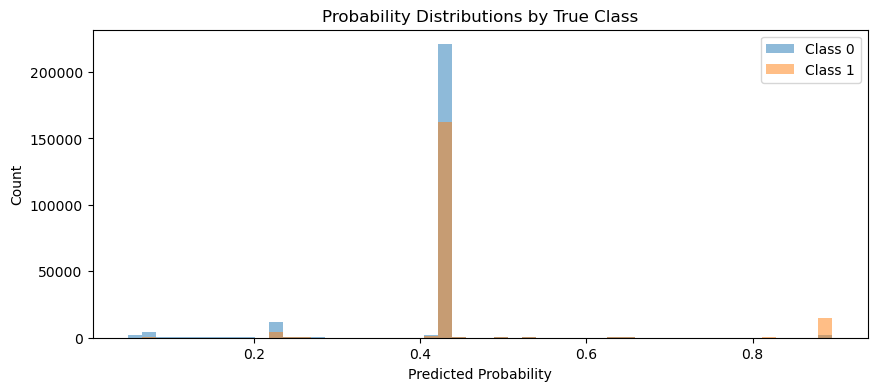

In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create the modeling pipeline
model = make_pipeline(
    RobustScaler(),  # Still useful for scaling, though Random Forests are less sensitive
    RandomForestClassifier(
        n_estimators=200,  # Number of trees in the forest
        max_depth=None,    # Let trees grow fully (can tune this)
        min_samples_split=2, 
        min_samples_leaf=1,
        class_weight='balanced',  # Automatic class balancing
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
)

# 2. Train with probability calibration (Random Forests sometimes benefit from calibration)
calibrated_model = CalibratedClassifierCV(model, cv=3)
calibrated_model.fit(X_train_scaled, y_train)

# 3. Make predictions (with adjusted threshold)
y_prob = calibrated_model.predict_proba(X_test_scaled)[:,1]
y_pred_adj = (y_prob > 0.4).astype(int)  # Using 0.4 threshold instead of default 0.5

# 4. Evaluate performance
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_adj))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adj))

# 5. Visual inspection of probabilities
plt.figure(figsize=(10, 4))
plt.hist(y_prob[y_test==0], bins=50, alpha=0.5, label='Class 0')
plt.hist(y_prob[y_test==1], bins=50, alpha=0.5, label='Class 1')
plt.legend()
plt.title("Probability Distributions by True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()